In [1]:
from phagesvisual import *
from xaa_lib import *

### Just run the block of code in defining functions 

## Definining Functions

In [4]:
from numba import njit, prange

@njit
def good_event(fa, fb, a, b, ab, o, xa, xaa, xb, xbb, sa, sb, omega):
    # Total density (rho)
    rho = a + b + ab + o ## Check
    delta = 0 ## Check
    fa += (a * sa + ab * sa * (1 - sb * sb / ( sa + sb + 10 ** -12))) * omega
    fb += (b * sb + ab * sb * (1 - sa * sa / ( sa + sb + 10 ** -12))) * omega
    a *= (1 - sa)
    b *= (1 - sb)
    ab *= (1 - sa - sb + sa * sb)
    FA = 1 - np.exp(-fa / (delta + rho)) ## Check
    Fsa = FA * np.exp(-fa / (delta + rho)) ## Check
    Fma = 1 - 2 * np.exp(-fa / (delta + rho)) + np.exp(-2 * fa / (delta + rho)) ## Check
    
    # Compute FB, Fsb, Fmb for B
    FB = 1 - np.exp(-fb / (delta + rho)) ## Check
    Fsb = FB * np.exp(-fb / (delta + rho)) ## Check
    Fmb = 1 - 2 * np.exp(-fb / (delta + rho)) + np.exp(-2 * fb / (delta + rho)) ## Check

    # Compute Plyt(A) and Plyt(B)
    Plyt_A = 1 - (xa * Fsa + xaa * Fma) / (FA + 1e-12) ## Check  # Avoid division by zero
    Plyt_B = 1 - (xb * Fsb + xbb * Fmb) / (FB + 1e-12) ## Check  # Avoid division by zero

    # Compute updated densities (a_star, b_star, ab_star, o_star)
    a_star = a + xa * o * Fsa * (1 - FB) - a * FB \
             + xaa * o * Fma * (1 - FB)  ## Check
    b_star = b + xb * o * Fsb * (1 - FA) - b * FA \
             + xbb * o * Fmb * (1 - FA)  ## Check
    ab_star = ab \
        + xa * b * Fsa + xaa * b * Fma \
        + xb * a * Fsb + xbb * a * Fmb \
        + Fsa * Fsb * o * xa * xb \
        + Fma * Fsb * o * xaa * xb \
        + Fsa * Fmb * o * xa * xbb \
        + Fma * Fmb * o * xaa * xbb      ## Check
    
    # Compute updated free phage concentrations (fa_star, fb_star)
    fa_star = ((1 - xa) * o * Fsa * (1 - FB * Plyt_B * fb / (fa + fb + 10 ** (-12))) * omega \
              + (1 - xa) * b * Fsa * omega \
              + (1 - xaa) * o * Fma * (1 - FB * Plyt_B * fb / (fa + fb + 10 ** (-12))) * omega \
              + (1 - xaa) * b * Fma * omega)  ## Check
    fb_star = (1 - xb) * o * Fsb * (1 - FA * Plyt_A * fa / (fa + fb + 10 ** (-12))) * omega \
              + (1 - xb) * a * Fsb * omega \
              + (1 - xbb) * o * Fmb * (1 - FA * Plyt_A * fa / (fa + fb + 10 ** (-12))) * omega \
              + (1 - xbb) * a * Fmb * omega ## Check

    o_star = 1 - (a + ab + b) ## Check

    a, b, ab, o, fa, fb = a_star, b_star, ab_star, o_star, fa_star, fb_star  ## Check

    return a, b, ab, o, fa, fb




@njit
def bad_event(a, a_0_n, b, b_0_n, ab, sa, sb, tbad, flux):
    bad_duration = max(1, int(np.floor(np.random.exponential(tbad))))  # Ensure duration is at least 1

    devide_b = bad_duration * sb + flux * np.log(1 + bad_duration * (flux + sb)) / (flux + sb)
    if abs(devide_b) < 1e-9:  # Avoid division by zero for b
        devide_b = 1e-9

    avg_b = b_0_n * np.log(1 + bad_duration * flux + bad_duration * sb) / devide_b

    denominator_b = sb + flux
    if denominator_b > 1e-9:
        b = avg_b * flux / denominator_b + (b - avg_b * flux / denominator_b) * 2.71828 ** (-(sb + flux) * bad_duration)
    else:
        b = 0  # Reset `b` to 0 if denominator is invalid

    devide_a = bad_duration * sa + flux * np.log(1 + bad_duration * (flux + sa)) / (flux + sa)
    if abs(devide_a) < 1e-9:  # Avoid division by zero for a
        devide_a = 1e-9

    avg_a = a_0_n * np.log(1 + bad_duration * flux + bad_duration * sa) / devide_a

    denominator_a = sa + flux
    if denominator_a > 1e-9:
        a = avg_a * flux / denominator_a + (a - avg_a * flux / denominator_a) * 2.71828 ** (-(sa + flux) * bad_duration)
    else:
        a = 0  # Reset `a` to 0 if denominator is invalid

    fa, fb = 0, 0

    ## BAD PROXY
    ab *= (1 - sa - sb) ** bad_duration
    return a, b, ab, fa, fb, bad_duration, avg_a, avg_b



from numba import njit, prange
import numpy as np

@njit
def simulation(xa, xaa, sa, xb, xbb, sb, omega, p, tbad, flux, seed, cutoff, wdw):
    # Preallocate arrays for rolling window storage
    h_a, h_b, h_ab, h_fa, h_fb = (
        np.zeros(wdw), np.zeros(wdw), np.zeros(wdw), np.zeros(wdw), np.zeros(wdw)
    )
    tbad_list = np.ones(wdw)

    fa, fb = 1, 1  # Initial values
    a, b, ab, o = 0, 0, 0, 1  # Initial conditions

    # Initiate system
    a, b, ab, o, fa, fb = good_event(fa, fb, a, b, ab, o, xa, xaa, xb, xbb, sa, sb, omega)

    # Initiating for deaths
    a_d, b_d = len(seed), len(seed)
    index = 0  # Rolling index for the arrays

    for i in prange(len(seed)):
        # Handle "death" conditions
        if i > a_d:
            a, fa, ab = 0, 0, 0
        if i > b_d:
            b, fb, ab = 0, 0, 0

        # Good Event
        if seed[i] > p:
            tbad_list[index] = 1

            # Calculate recent values within the rolling window
            start = max(0, index - wdw + 1)
            recent_fa = h_fa[start:index + 1]
            recent_fb = h_fb[start:index + 1]
            recent_tbad = tbad_list[start:index + 1]

            # Perform flux calculations with recent values
            if len(recent_fa) > 0 and len(recent_tbad) > 0:
                fa += (np.sum(recent_fa) / (np.sum(recent_tbad) + 1e-9)) * flux
                fb += (np.sum(recent_fb) / (np.sum(recent_tbad) + 1e-9)) * flux

            # Update system state with the good event
            a, b, ab, o, fa, fb = good_event(fa, fb, a, b, ab, o, xa, xaa, xb, xbb, sa, sb, omega)

            # Adjust populations
            a -= a * flux
            b -= b * flux

        # Bad Event
        elif seed[i] < p:
            # Use last good event averages
            a, b, ab, fa, fb, bad_duration, avg_a, avg_b = bad_event(a, 0, b, 0, ab, sa, sb, tbad, flux)

            # Track bad duration
            tbad_list[index] = bad_duration

        # Flux Donations
        fa -= fa * flux
        fb -= fb * flux

        # Store variables in rolling arrays
        h_a[index], h_b[index], h_ab[index], h_fa[index], h_fb[index] = a, b, ab, fa, fb

        # Death Criterion for A
        if i >= wdw and a_d == len(seed):
            if np.all(h_fa + h_a < cutoff):
                a_d = i
                a, fa = 0, 0

        # Death Criterion for B
        if i >= wdw and b_d == len(seed):
            if np.all(h_fb + h_b < cutoff):
                b_d = i
                b, fb = 0, 0

        # Increment the rolling index
        index = (index + 1) % wdw

    # Return history and death iterations
    return h_a, h_b, h_ab, h_fa, h_fb, tbad_list, a_d, b_d



## Defining grid simulations
def simulate_omega_flux_with_progress(grid_results, omega_values, flux_values, xb_values, sb_values, num_simulations):
    for flux_idx in prange(len(flux_values)):  # Loop over flux values
        flux = flux_values[flux_idx]
        print(f"Starting flux_idx: {flux_idx}/{len(flux_values)}")

        for omega_idx in prange(len(omega_values)):  # Loop over omega values
            omega = omega_values[omega_idx]
            print(f"  Starting omega_idx: {omega_idx}/{len(omega_values)}")

            for xb in xb_values:
                for xbb in sb_values:
                    a_win = 0
                    b_win = 0

                    for j in prange(num_simulations):
                        if j % 5 == 0:  # Progress check
                            print(f"    Simulation progress: j = {j}/{num_simulations}")

                        seed = np.random.rand(iterations)
                        seed[0] = 1
                        sb = 10 ** -3
                        ## Simulation
                        h_a, h_b, h_ab, h_fa, h_fb, tbad_list, a_d, b_d = simulation(xa, xaa, sa, xb, xbb, sb, omega, p, tbad, flux, seed, cutoff, wdw)
                        if b_d > a_d and a_d + b_d > 100:
                            b_win += 1
                        elif a_d > b_d and a_d + b_d > 100:
                            a_win += 1

                        if a_win >= num_simulations/3 + b_win:
                            grid_results[flux_idx, omega_idx] = 0  # A wins
                            break

                        if b_win >= num_simulations/3 + a_win:
                            grid_results[flux_idx, omega_idx] = 1  # B wins
                            break

                    if grid_results[flux_idx, omega_idx] != -1:
                        break  # Exit inner loops if a winner is determined
                
                if grid_results[flux_idx, omega_idx] != -1:
                    break

    return grid_results

## Running single Simulation, printing death States

In [85]:
# Inputs
iterations = 10 ** 4
seed, tbad = np.random.rand(10  ** 5), 10 ** 3  # Random seed for 100 iterations
xa, xaa, sa = 0.01, 0, 0
xb, xbb, sb = 0.05, 0.01, 10 ** -3
omega, p, flux = 5, 0.1, 10 ** -4
cutoff = 10 ** -9
wdw = 10 ** 3

# Call the simulation function
h_a, h_b, h_ab, h_fa, h_fb, tbad_list, a_d, b_d, b_avg, b_bad_event_history = simulation(xa, xaa, sa, xb, xbb, sb, omega, p, tbad, flux, seed, cutoff, wdw)
print("Death of A:", a_d,"Death of B:", b_d)

Death of A: 83 Death of B: 100000


## Grid

In [9]:

## Fixing the Lytic A phage
xa, xaa, sa = 0, 0, 0

## Setting up environment
p = 0.1
tbad = 10 ** 3
iterations = 10 ** 5         
cutoff = 1e-9
wdw = 400
deathlen = 5

# Define spaces for omega and flux (logarithmic space)
omega_values_space = np.logspace(np.log10(5), np.log10(200),16)
omega_values = omega_values_space
flux_values_space = np.logspace(-9,np.log10(0.5), 16)
flux_values = flux_values_space

## Gathering Statistics
num_simulations = 10

## Defining opponents for lytic A phage (Could make logspaces of both x and sigma)
xb_values = [0.01]
xbb_values = [0.01]
sb_values = [10 ** -3]
# 2D array to store results for each (omega, flux) pair (0 for A, 1 for B, -1 for undetermined)
grid_results = -1 * np.ones((len(flux_values), len(omega_values)))

# Start timing the loop
start_time = time.time()

# Call the optimized function
grid_results = simulate_omega_flux_with_progress(grid_results, omega_values, flux_values, xb_values, sb_values, num_simulations)

# End timing
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Total simulation time: {elapsed_time:.2f} seconds")




Starting flux_idx: 0/5
  Starting omega_idx: 0/5
    Simulation progress: j = 0/10
  Starting omega_idx: 1/5
    Simulation progress: j = 0/10
  Starting omega_idx: 2/5
    Simulation progress: j = 0/10
  Starting omega_idx: 3/5
    Simulation progress: j = 0/10
  Starting omega_idx: 4/5
    Simulation progress: j = 0/10
    Simulation progress: j = 5/10
Starting flux_idx: 1/5
  Starting omega_idx: 0/5
    Simulation progress: j = 0/10
  Starting omega_idx: 1/5
    Simulation progress: j = 0/10
  Starting omega_idx: 2/5
    Simulation progress: j = 0/10
  Starting omega_idx: 3/5
    Simulation progress: j = 0/10
  Starting omega_idx: 4/5
    Simulation progress: j = 0/10
    Simulation progress: j = 5/10
Starting flux_idx: 2/5
  Starting omega_idx: 0/5
    Simulation progress: j = 0/10
  Starting omega_idx: 1/5
    Simulation progress: j = 0/10
  Starting omega_idx: 2/5
    Simulation progress: j = 0/10
  Starting omega_idx: 3/5
    Simulation progress: j = 0/10
  Starting omega_idx: 4

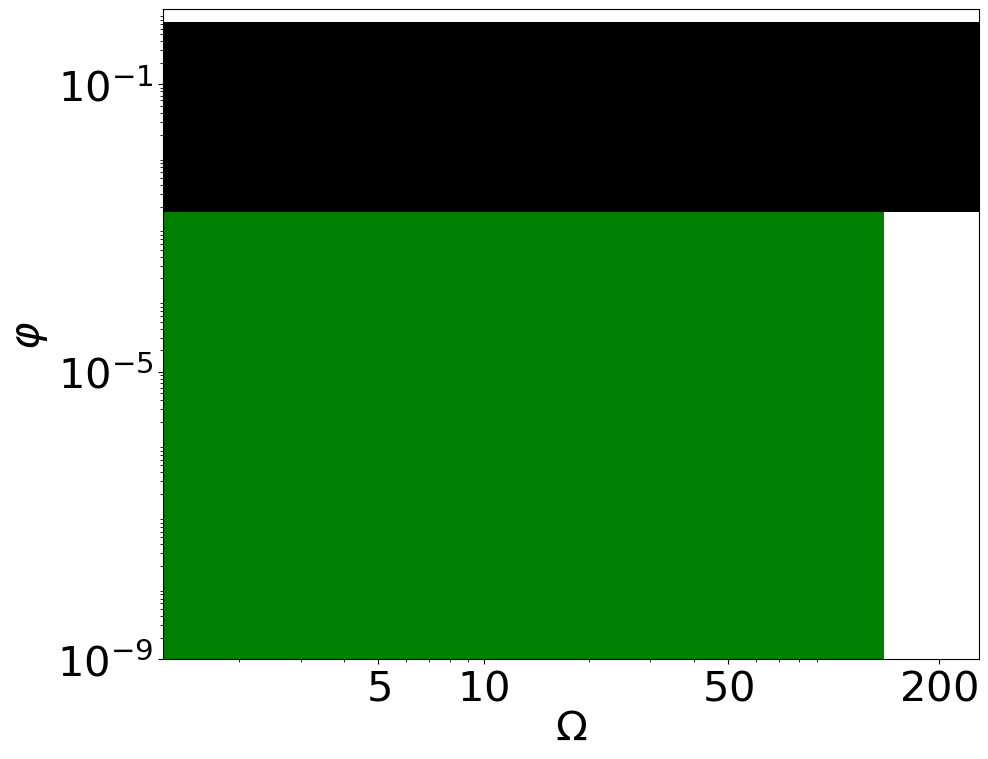

In [10]:
import matplotlib.colors as mcolors
from matplotlib.ticker import LogLocator

# Define the colormap and normalization
cmap = mcolors.ListedColormap(['white','black', 'green'])  # Lytic (-1) -> black, Temperate (1) -> green, White means no extinction, so no clear winner.
bounds = [-2,-0.5, 0.5, 1.5]  # Set boundaries to ensure correct color mapping
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the 2D grid with pcolormesh (handles non-linear grids)
plt.figure(figsize=(10, 7.7))  # Adjust the figure size
X, Y = np.meshgrid(omega_values, flux_values)  # Create grid for log-spaced values
plt.pcolormesh(X, Y, grid_results, cmap=cmap, norm=norm, shading='auto')

# Set a logarithmic scale for both axes
plt.xscale('log')
plt.yscale('log')

# Set ticks for log-scale axes
x_ticks = [5, 10, 50, 200]
y_ticks = [1e-9, 1e-5, 1e-1]

plt.xticks(x_ticks, labels=[r"$5$", r"$10$", r"$50$", r"$200$"], fontsize=30)
plt.yticks(y_ticks, labels=[r"$10^{-9}$", r"$10^{-5}$", r"$10^{-1}$"], fontsize=30)

# Add axis labels
plt.xlabel(r'$\Omega$', fontsize=30, labelpad=0)
plt.ylabel(r'$\varphi$', fontsize=30, labelpad=5)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### Testing MOI dependance on winning regions. Not really central to paper.


Results for xbb = 0.05 (Elapsed time: 459.80 seconds):


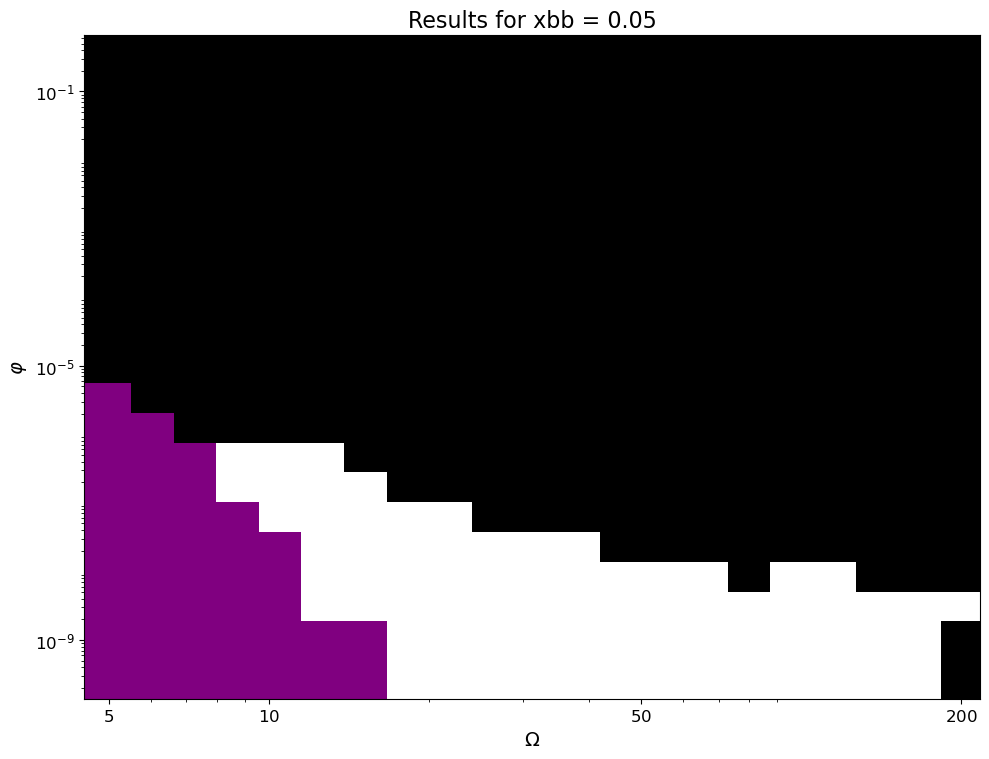


Results for xbb = 0.1 (Elapsed time: 303.42 seconds):


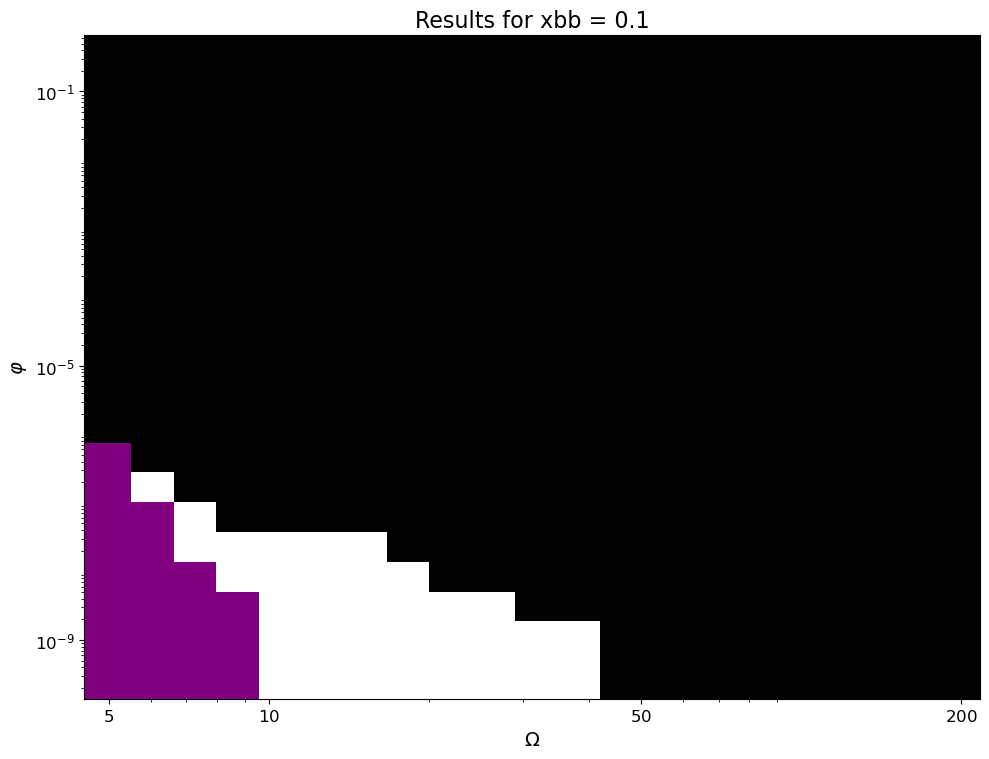


Results for xbb = 0.5 (Elapsed time: 510.21 seconds):


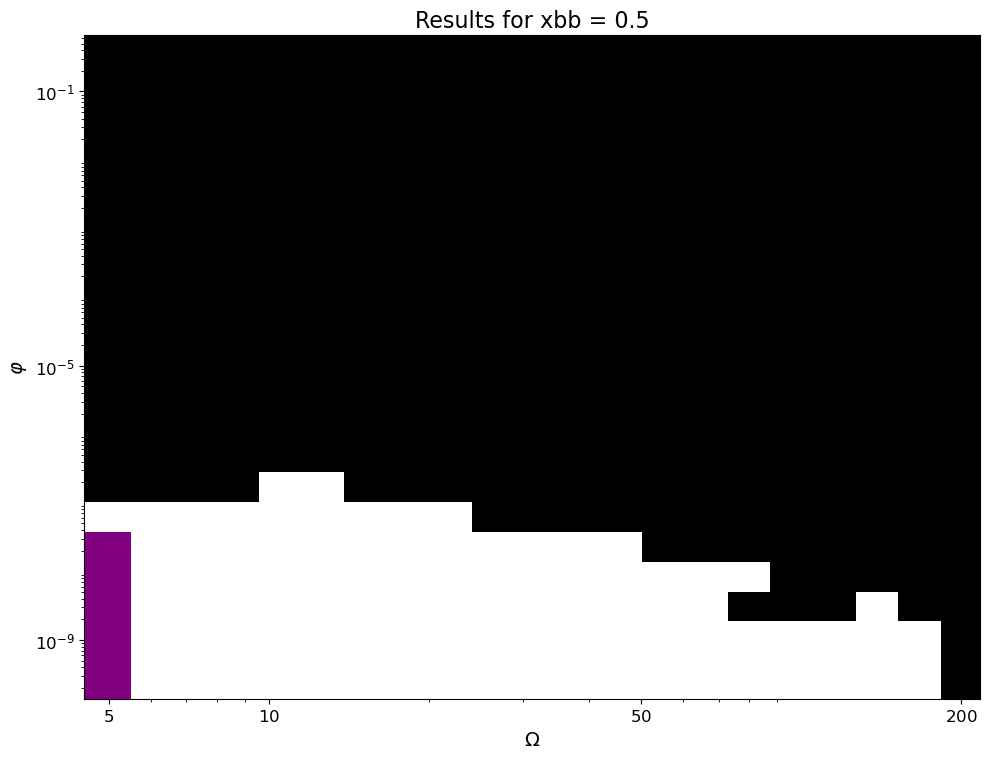


Results for xbb = 1 (Elapsed time: 367.96 seconds):


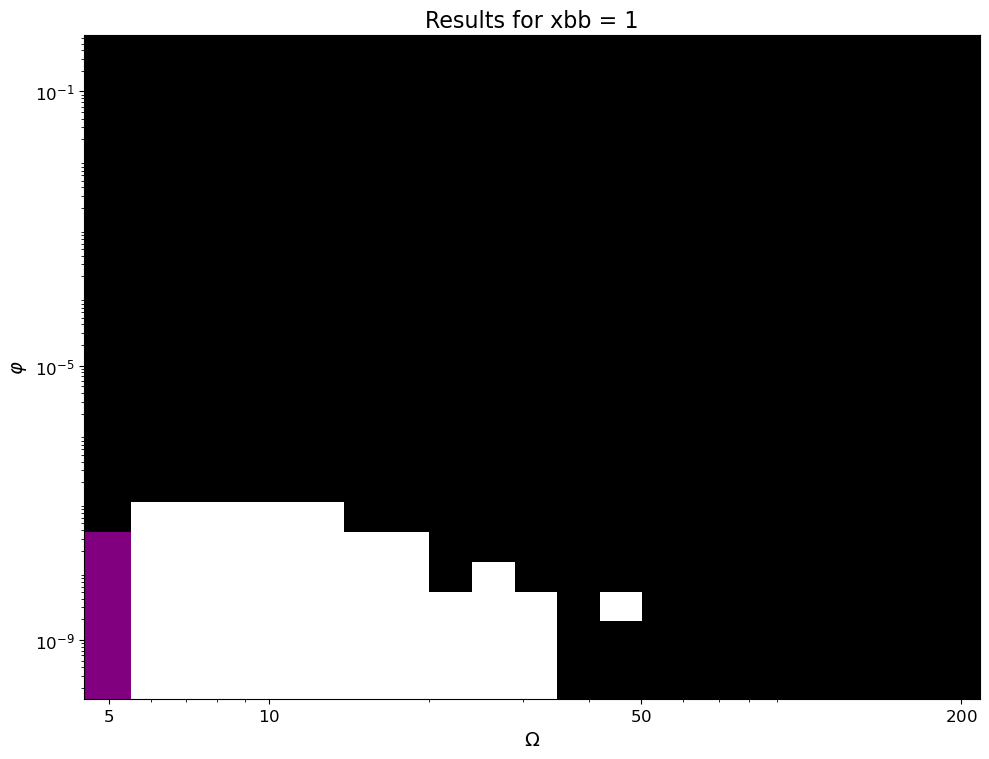

In [43]:
from numba import njit, prange
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Example fixed parameters for A
xa = 0
xaa = 0
sa = 0
p = 0.1
tbad = 10 ** 3
iterations = 10 ** 5
cutoff = 1e-9
wdw = 400
deathlen = 5

# Define spaces for omega and flux (logarithmic space)
omega_values_space = np.logspace(np.log10(5), np.log10(200), 21)
omega_values = omega_values_space
flux_values_space = np.logspace(-9, np.log10(0.5), 21)
flux_values = flux_values_space

num_simulations = 100

# Fixed xb values
xb_values = [0.01]

# Different xbb values to test
xbb_values_list = [0.05, 0.1, 0.5, 1]
sb_values = [10 ** -3]

def simulate_omega_flux(grid_results, omega_values, flux_values, xb, xbb, sb_values, num_simulations):
    for flux_idx in prange(len(flux_values)):  # Loop over flux values
        flux = flux_values[flux_idx]
        
        for omega_idx in prange(len(omega_values)):  # Loop over omega values
            omega = omega_values[omega_idx]

            a_win = 0
            b_win = 0

            for j in prange(num_simulations):
                seed = np.random.rand(iterations)
                seed[0] = 1
                sb = 10 ** -3
                # Simulation placeholder function (replace with actual simulation logic)
                h_a, h_b, h_ab, h_fa, h_fb, tbad_list, a_d, b_d = simulation(xa, xaa, sa, xb, xbb, sb, omega, p, tbad, flux, seed, cutoff, wdw)

                if b_d > a_d and a_d + b_d > 100:
                    b_win += 1
                elif a_d > b_d and a_d + b_d > 100:
                    a_win += 1

                if a_win >= 5 + b_win:
                    grid_results[flux_idx, omega_idx] = 0  # A wins
                    break

                if b_win >= 5 + a_win:
                    grid_results[flux_idx, omega_idx] = 1  # B wins
                    break

    return grid_results

# Run simulation for each xbb value
for xbb in xbb_values_list:
    grid_results = -1 * np.ones((len(flux_values), len(omega_values)))
    start_time = time.time()

    # Call the simulation function
    grid_results = simulate_omega_flux(grid_results, omega_values, flux_values, xb_values[0], xbb, sb_values, num_simulations)

    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    print(f"\nResults for xbb = {xbb} (Elapsed time: {elapsed_time:.2f} seconds):")

    # Define the colormap and normalization
    cmap = mcolors.ListedColormap(['white', 'black', 'purple'])  # -1: black, 0: white, 1: purple
    bounds = [-2, -0.5, 0.5, 1.5]  # Boundaries for colormap
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Plot the 2D grid
    plt.figure(figsize=(10, 7.7))
    X, Y = np.meshgrid(omega_values, flux_values)
    plt.pcolormesh(X, Y, grid_results, cmap=cmap, norm=norm, shading='auto')

    # Set logarithmic scales
    plt.xscale('log')
    plt.yscale('log')

    # Set ticks for log-scale axes
    x_ticks = [5, 10, 50, 200]
    y_ticks = [1e-9, 1e-5, 1e-1]

    plt.xticks(x_ticks, labels=[r"$5$", r"$10$", r"$50$", r"$200$"], fontsize=12)
    plt.yticks(y_ticks, labels=[r"$10^{-9}$", r"$10^{-5}$", r"$10^{-1}$"], fontsize=12)

    # Add labels and title
    plt.xlabel(r'$\Omega$', fontsize=14)
    plt.ylabel(r'$\varphi$', fontsize=14)
    plt.title(f'Results for xbb = {xbb}', fontsize=16)

    # Show the plot
    plt.tight_layout()
    plt.show()


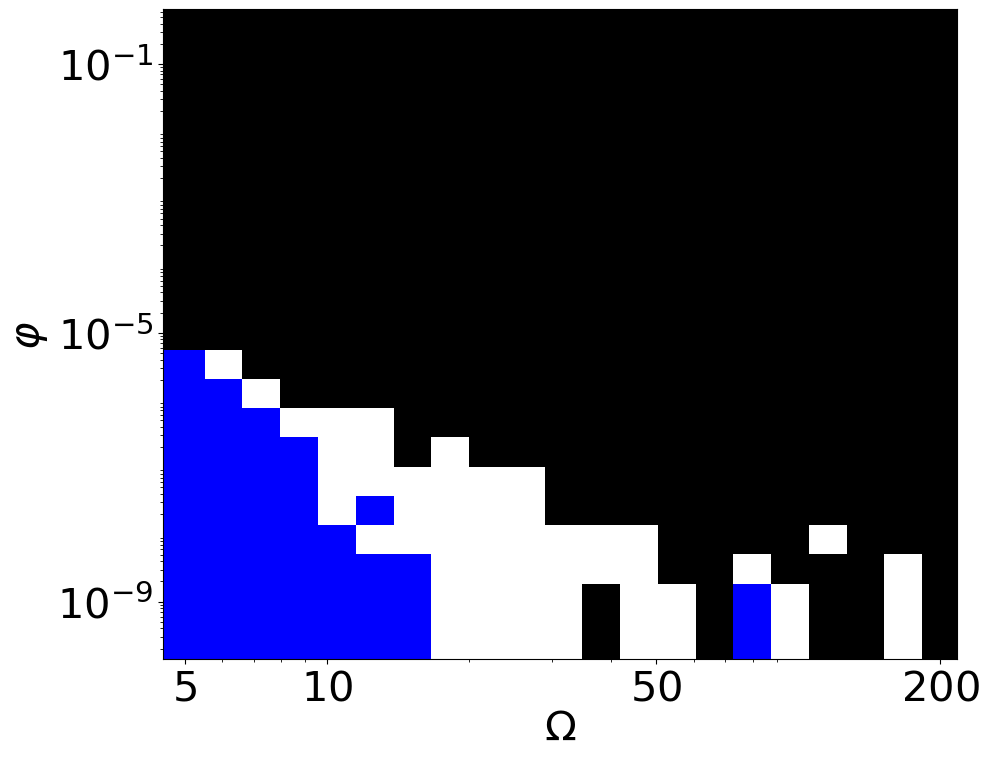

0.5

In [25]:
import matplotlib.colors as mcolors
from matplotlib.ticker import LogLocator

# Define the colormap and normalization
cmap = mcolors.ListedColormap(['white','black', 'blue'])  # Lytic (-1) -> black, Temperate (1) -> yellow
bounds = [-2,-0.5, 0.5, 1.5]  # Set boundaries to ensure correct color mapping
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the 2D grid with pcolormesh (handles non-linear grids)
plt.figure(figsize=(10, 7.7))  # Adjust the figure size
X, Y = np.meshgrid(omega_values, flux_values)  # Create grid for log-spaced values
plt.pcolormesh(X, Y, grid_results, cmap=cmap, norm=norm, shading='auto')

# Set a logarithmic scale for both axes
plt.xscale('log')
plt.yscale('log')

# Set ticks for log-scale axes
x_ticks = [5, 10, 50, 200]
y_ticks = [1e-9, 1e-5, 1e-1]

plt.xticks(x_ticks, labels=[r"$5$", r"$10$", r"$50$", r"$200$"], fontsize=30)
plt.yticks(y_ticks, labels=[r"$10^{-9}$", r"$10^{-5}$", r"$10^{-1}$"], fontsize=30)

# Add axis labels
plt.xlabel(r'$\Omega$', fontsize=30, labelpad=0)
plt.ylabel(r'$\varphi$', fontsize=30, labelpad=5)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
0.5